In [137]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [138]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

## Image to Tensor Conversions

In [287]:
imsize = 256

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [409]:
set_folder = "Set5"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [410]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [298]:
device = torch.device("cuda")
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [263]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [264]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [265]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [266]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [273]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

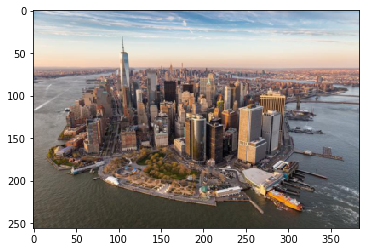

In [411]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [404]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.01)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

In [ ]:
output = style_transfer(vgg, content, style, input_img, iters=1000, style_w=100000000, content_w=1)
output.save("UpdatedSets/"+set_folder+"/output3.png")

Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000001 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000023 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000060 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.000117 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000196 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000290 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000411 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000551 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000719 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.000911 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.001131 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.001383 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.001666 
Iteratio

Iteration 7:  Style Loss = 0.000001  Content Loss = 0.080849 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.081306 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.081765 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.082217 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.082675 
Iteration 7:  Style Loss = 0.000001  Content Loss = 0.083130 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.083586 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.084042 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.084496 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.084950 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.085403 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.085855 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.086308 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.086760 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.087214 
Iteration 8:  Style Loss = 0.000001  Content Loss = 0.087666 
Iteratio

Iteration 14:  Style Loss = 0.000000  Content Loss = 0.152538 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.152968 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.153396 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.153803 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.154210 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.154614 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.155008 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.155401 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.155781 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.156164 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.156544 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.156914 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.157281 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.157641 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.157998 
Iteration 15:  Style Loss = 0.000000  Content Loss = 0.

Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183845 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183991 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184138 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184285 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184429 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184573 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184716 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.184857 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185000 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185140 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185283 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185420 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185558 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185696 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.185832 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.

Iteration 27:  Style Loss = 0.000000  Content Loss = 0.198643 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.198728 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.198814 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.198899 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.198983 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.199069 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.199148 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.199232 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.199316 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.199396 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.199479 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.199560 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.199641 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.199724 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.199804 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207176 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207217 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207258 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207300 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207341 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207381 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207420 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207460 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207500 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207540 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207578 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207614 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207651 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207687 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.207723 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.

Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209948 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209949 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209950 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209951 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209951 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.209951 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209951 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209951 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209950 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209949 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209947 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209946 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209943 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209941 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.209938 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.

Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207249 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207213 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207174 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207138 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207101 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207064 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.207027 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206990 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206953 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206915 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206878 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206841 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206804 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.206765 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.206729 
Iteration 48:  Style Loss = 0.000000  Content Loss = 0.

Iteration 53:  Style Loss = 0.000000  Content Loss = 0.202873 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.202846 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202820 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202794 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202767 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202742 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202715 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202689 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202663 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202637 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202611 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202585 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202559 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202534 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.202508 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198826 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198788 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198751 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198713 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198677 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198640 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198603 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198566 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198529 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.198493 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.198457 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.198419 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.198384 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.198348 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.198311 
Iteration 61:  Style Loss = 0.000000  Content Loss = 0.

Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194240 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194205 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194170 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194135 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194100 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194065 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.194029 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193996 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193960 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193924 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193889 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193854 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193818 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193781 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.193745 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.

Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188582 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188531 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188481 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188430 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188378 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.188325 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188273 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188218 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188166 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188111 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188057 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.188007 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.187955 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.187901 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.187850 
Iteration 74:  Style Loss = 0.000000  Content Loss = 0.

Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181899 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181851 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181805 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181760 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181715 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181670 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181625 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181580 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181537 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181493 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181447 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181402 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181356 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.181313 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.181269 
Iteration 81:  Style Loss = 0.000000  Content Loss = 0.

Iteration 86:  Style Loss = 0.000000  Content Loss = 0.176757 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.176725 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176691 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176656 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176624 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176591 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176558 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176525 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176490 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176458 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176425 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176394 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176361 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176327 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.176294 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172381 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172349 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172316 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172283 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172249 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172215 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172182 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172147 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172115 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.172081 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.172047 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.172013 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.171979 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.171946 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.171913 
Iteration 94:  Style Loss = 0.000000  Content Loss = 0.

Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167960 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167925 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167889 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167853 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167817 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167782 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167747 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167711 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167674 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167637 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167601 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167565 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167529 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167493 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.167457 
Iteration 100:  Style Loss = 0.000000  C

Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162693 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162649 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162605 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162563 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162521 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162479 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162439 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.162394 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162349 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162307 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162263 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162221 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162181 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162137 
Iteration 107:  Style Loss = 0.000000  Content Loss = 0.162096 
Iteration 107:  Style Loss = 0.000000  C

Iteration 113:  Style Loss = 0.000000  Content Loss = 0.157167 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.157127 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.157086 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.157043 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.157003 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156960 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156920 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156879 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156834 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156791 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156752 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156709 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156668 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156627 
Iteration 113:  Style Loss = 0.000000  Content Loss = 0.156586 
Iteration 113:  Style Loss = 0.000000  C

Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152395 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152365 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152336 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152307 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152279 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152250 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152220 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.152193 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152166 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152138 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152110 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152080 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152050 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.152022 
Iteration 120:  Style Loss = 0.000000  Content Loss = 0.151994 
Iteration 120:  Style Loss = 0.000000  C

Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148909 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148881 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148854 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148823 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148795 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148765 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148735 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148707 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148676 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148647 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148617 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148587 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148556 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148527 
Iteration 126:  Style Loss = 0.000000  Content Loss = 0.148497 
Iteration 126:  Style Loss = 0.000000  C

Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145163 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145138 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145116 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145092 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145068 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145045 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.145020 
Iteration 132:  Style Loss = 0.000000  Content Loss = 0.144996 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144973 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144949 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144927 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144903 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144879 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144856 
Iteration 133:  Style Loss = 0.000000  Content Loss = 0.144832 
Iteration 133:  Style Loss = 0.000000  C

Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142259 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142233 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142207 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142183 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142159 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142136 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142112 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142088 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142063 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142038 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.142015 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.141989 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.141965 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.141939 
Iteration 139:  Style Loss = 0.000000  Content Loss = 0.141914 
Iteration 139:  Style Loss = 0.000000  C

Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139312 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139293 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139275 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139257 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139240 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139222 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139203 
Iteration 145:  Style Loss = 0.000000  Content Loss = 0.139186 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139168 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139150 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139133 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139115 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139097 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139079 
Iteration 146:  Style Loss = 0.000000  Content Loss = 0.139062 
Iteration 146:  Style Loss = 0.000000  C

Iteration 152:  Style Loss = 0.000000  Content Loss = 0.137054 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.137034 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.137015 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136995 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136975 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136955 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136935 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136916 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136896 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136875 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136854 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136834 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136813 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136793 
Iteration 152:  Style Loss = 0.000000  Content Loss = 0.136772 
Iteration 152:  Style Loss = 0.000000  C

Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134280 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134258 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134238 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134218 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134197 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134174 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134155 
Iteration 158:  Style Loss = 0.000000  Content Loss = 0.134135 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134115 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134095 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134074 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134054 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134034 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.134013 
Iteration 159:  Style Loss = 0.000000  Content Loss = 0.133993 
Iteration 159:  Style Loss = 0.000000  C

Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131824 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131806 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131789 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131772 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131754 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131737 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131720 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131704 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131687 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131671 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131654 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131636 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131620 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131604 
Iteration 165:  Style Loss = 0.000000  Content Loss = 0.131587 
Iteration 165:  Style Loss = 0.000000  C

Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129936 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129924 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129911 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129899 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129887 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129876 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129864 
Iteration 171:  Style Loss = 0.000000  Content Loss = 0.129853 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129840 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129828 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129815 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129802 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129790 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129778 
Iteration 172:  Style Loss = 0.000000  Content Loss = 0.129766 
Iteration 172:  Style Loss = 0.000000  C

Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128279 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128265 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128252 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128238 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128224 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128210 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128197 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128183 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128171 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128158 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128145 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128132 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128118 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128104 
Iteration 178:  Style Loss = 0.000000  Content Loss = 0.128091 
Iteration 178:  Style Loss = 0.000000  C

Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126534 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126521 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126509 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126495 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126481 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126469 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126456 
Iteration 184:  Style Loss = 0.000000  Content Loss = 0.126443 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126429 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126417 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126404 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126392 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126379 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126366 
Iteration 185:  Style Loss = 0.000000  Content Loss = 0.126352 
Iteration 185:  Style Loss = 0.000000  C

Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124713 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124698 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124684 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124670 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124655 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124640 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124625 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124609 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124595 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124580 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124566 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124552 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124537 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124523 
Iteration 191:  Style Loss = 0.000000  Content Loss = 0.124508 
Iteration 191:  Style Loss = 0.000000  C

Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123221 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123212 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123204 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123197 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123188 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123180 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123172 
Iteration 197:  Style Loss = 0.000000  Content Loss = 0.123164 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123156 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123147 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123139 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123131 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123123 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123116 
Iteration 198:  Style Loss = 0.000000  Content Loss = 0.123107 
Iteration 198:  Style Loss = 0.000000  C

Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122211 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122203 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122193 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122185 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122175 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122167 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122158 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122149 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122141 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122132 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122122 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122114 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122105 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122096 
Iteration 204:  Style Loss = 0.000000  Content Loss = 0.122086 
Iteration 204:  Style Loss = 0.000000  C

Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120963 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120954 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120945 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120936 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120926 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120918 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120909 
Iteration 210:  Style Loss = 0.000000  Content Loss = 0.120900 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120892 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120883 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120875 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120866 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120857 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120848 
Iteration 211:  Style Loss = 0.000000  Content Loss = 0.120840 
Iteration 211:  Style Loss = 0.000000  C

Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119899 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119891 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119883 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119875 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119867 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119858 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119850 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119843 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119835 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119827 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119820 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119811 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119804 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119796 
Iteration 217:  Style Loss = 0.000000  Content Loss = 0.119788 
Iteration 217:  Style Loss = 0.000000  C

Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118932 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118925 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118920 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118913 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118907 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118901 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118895 
Iteration 223:  Style Loss = 0.000000  Content Loss = 0.118890 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118884 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118878 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118873 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118867 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118861 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118855 
Iteration 224:  Style Loss = 0.000000  Content Loss = 0.118849 
Iteration 224:  Style Loss = 0.000000  C

Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118268 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118263 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118258 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118253 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118248 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118243 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118238 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118232 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118227 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118222 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118217 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118212 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118206 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118200 
Iteration 230:  Style Loss = 0.000000  Content Loss = 0.118195 
Iteration 230:  Style Loss = 0.000000  C

Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117447 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117441 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117434 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117426 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117419 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117413 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117406 
Iteration 236:  Style Loss = 0.000000  Content Loss = 0.117400 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117393 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117386 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117379 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117373 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117366 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117359 
Iteration 237:  Style Loss = 0.000000  Content Loss = 0.117352 
Iteration 237:  Style Loss = 0.000000  C

Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116595 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116590 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116584 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116579 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116573 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116567 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116561 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116555 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116549 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116543 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116538 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116532 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116526 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116521 
Iteration 243:  Style Loss = 0.000000  Content Loss = 0.116515 
Iteration 243:  Style Loss = 0.000000  C

Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115942 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115938 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115934 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115929 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115925 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115921 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115917 
Iteration 249:  Style Loss = 0.000000  Content Loss = 0.115914 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115910 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115905 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115901 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115897 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115893 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115889 
Iteration 250:  Style Loss = 0.000000  Content Loss = 0.115884 
Iteration 250:  Style Loss = 0.000000  C

Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115405 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115401 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115396 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115392 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115388 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115384 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115380 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115375 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115371 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115367 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115363 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115359 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115355 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115351 
Iteration 256:  Style Loss = 0.000000  Content Loss = 0.115347 
Iteration 256:  Style Loss = 0.000000  C

Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114890 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114886 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114883 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114879 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114875 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114872 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114868 
Iteration 262:  Style Loss = 0.000000  Content Loss = 0.114864 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114861 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114857 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114853 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114849 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114845 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114842 
Iteration 263:  Style Loss = 0.000000  Content Loss = 0.114838 
Iteration 263:  Style Loss = 0.000000  C

Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114353 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114349 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114344 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114339 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114334 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114330 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114326 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114321 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114317 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114312 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114308 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114304 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114299 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114295 
Iteration 269:  Style Loss = 0.000000  Content Loss = 0.114291 
Iteration 269:  Style Loss = 0.000000  C

Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113837 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113833 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113830 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113827 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113824 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113821 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113817 
Iteration 275:  Style Loss = 0.000000  Content Loss = 0.113814 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113812 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113809 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113805 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113803 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113800 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113796 
Iteration 276:  Style Loss = 0.000000  Content Loss = 0.113794 
Iteration 276:  Style Loss = 0.000000  C

Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113451 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113447 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113444 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113441 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113437 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113434 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113430 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113427 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113424 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113421 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113417 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113414 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113411 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113407 
Iteration 282:  Style Loss = 0.000000  Content Loss = 0.113404 
Iteration 282:  Style Loss = 0.000000  C

Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113032 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113029 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113026 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113024 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113021 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113018 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113015 
Iteration 288:  Style Loss = 0.000000  Content Loss = 0.113012 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.113010 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.113007 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.113004 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.113002 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.112999 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.112996 
Iteration 289:  Style Loss = 0.000000  Content Loss = 0.112993 
Iteration 289:  Style Loss = 0.000000  C

Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112700 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112697 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112695 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112692 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112690 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112687 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112684 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112681 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112679 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112676 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112673 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112671 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112668 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112665 
Iteration 295:  Style Loss = 0.000000  Content Loss = 0.112662 
Iteration 295:  Style Loss = 0.000000  C

Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112362 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112360 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112357 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112355 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112353 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112351 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112348 
Iteration 301:  Style Loss = 0.000000  Content Loss = 0.112346 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112343 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112341 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112338 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112336 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112334 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112332 
Iteration 302:  Style Loss = 0.000000  Content Loss = 0.112330 
Iteration 302:  Style Loss = 0.000000  C

Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112075 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112072 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112070 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112068 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112065 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112063 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112061 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112059 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112056 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112054 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112052 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112050 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112047 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112045 
Iteration 308:  Style Loss = 0.000000  Content Loss = 0.112042 
Iteration 308:  Style Loss = 0.000000  C

Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111760 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111758 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111756 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111753 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111751 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111749 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111746 
Iteration 314:  Style Loss = 0.000000  Content Loss = 0.111744 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111742 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111739 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111737 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111734 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111732 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111730 
Iteration 315:  Style Loss = 0.000000  Content Loss = 0.111728 
Iteration 315:  Style Loss = 0.000000  C

Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111497 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111495 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111493 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111492 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111490 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111489 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111487 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111485 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111484 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111482 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111481 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111479 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111478 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111476 
Iteration 321:  Style Loss = 0.000000  Content Loss = 0.111475 
Iteration 321:  Style Loss = 0.000000  C

Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111324 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111323 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111322 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111320 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111319 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111318 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111317 
Iteration 327:  Style Loss = 0.000000  Content Loss = 0.111316 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111315 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111314 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111313 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111312 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111311 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111310 
Iteration 328:  Style Loss = 0.000000  Content Loss = 0.111309 
Iteration 328:  Style Loss = 0.000000  C

Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111198 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111197 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111196 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111195 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111194 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111193 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111192 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111191 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111190 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111189 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111188 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111187 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111186 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111185 
Iteration 334:  Style Loss = 0.000000  Content Loss = 0.111184 
Iteration 334:  Style Loss = 0.000000  C

Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111039 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111038 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111036 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111035 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111034 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111032 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111031 
Iteration 340:  Style Loss = 0.000000  Content Loss = 0.111029 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111028 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111027 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111026 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111024 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111023 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111022 
Iteration 341:  Style Loss = 0.000000  Content Loss = 0.111020 
Iteration 341:  Style Loss = 0.000000  C

Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110892 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110891 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110890 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110889 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110888 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110887 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110886 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110885 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110884 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110883 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110882 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110881 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110881 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110880 
Iteration 347:  Style Loss = 0.000000  Content Loss = 0.110879 
Iteration 347:  Style Loss = 0.000000  C

Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110785 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110785 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110784 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110783 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110783 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110782 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110781 
Iteration 353:  Style Loss = 0.000000  Content Loss = 0.110781 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110780 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110779 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110779 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110778 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110777 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110777 
Iteration 354:  Style Loss = 0.000000  Content Loss = 0.110776 
Iteration 354:  Style Loss = 0.000000  C

Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110728 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110728 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110728 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110727 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110727 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110727 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110727 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110726 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110726 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110726 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110726 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110725 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110725 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110725 
Iteration 360:  Style Loss = 0.000000  Content Loss = 0.110725 
Iteration 360:  Style Loss = 0.000000  C

Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110701 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110701 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110701 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110700 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110700 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110700 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110700 
Iteration 366:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110699 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110698 
Iteration 367:  Style Loss = 0.000000  Content Loss = 0.110698 
Iteration 367:  Style Loss = 0.000000  C

Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110670 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110670 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110670 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110670 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110669 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110669 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110669 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110669 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110668 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110668 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110668 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110668 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110667 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110667 
Iteration 373:  Style Loss = 0.000000  Content Loss = 0.110667 
Iteration 373:  Style Loss = 0.000000  C

Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110635 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110635 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110635 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110635 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110634 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110634 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110634 
Iteration 379:  Style Loss = 0.000000  Content Loss = 0.110633 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110633 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110633 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110632 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110632 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110632 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110632 
Iteration 380:  Style Loss = 0.000000  Content Loss = 0.110631 
Iteration 380:  Style Loss = 0.000000  C

Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110597 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110597 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110596 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110596 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110596 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110596 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110595 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110595 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110595 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110595 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110594 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110594 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110594 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110593 
Iteration 386:  Style Loss = 0.000000  Content Loss = 0.110593 
Iteration 386:  Style Loss = 0.000000  C

Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110572 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110572 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110572 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110572 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110572 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 392:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110571 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110570 
Iteration 393:  Style Loss = 0.000000  Content Loss = 0.110570 
Iteration 393:  Style Loss = 0.000000  C

Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110561 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  Content Loss = 0.110560 
Iteration 399:  Style Loss = 0.000000  C

Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110550 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110550 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110550 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110550 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110550 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 405:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110549 
Iteration 406:  Style Loss = 0.000000  Content Loss = 0.110548 
Iteration 406:  Style Loss = 0.000000  C

Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110527 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110526 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110526 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110526 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110525 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110525 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110525 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110525 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110524 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110524 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110524 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110524 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110523 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110523 
Iteration 412:  Style Loss = 0.000000  Content Loss = 0.110523 
Iteration 412:  Style Loss = 0.000000  C

Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110479 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110478 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110478 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110477 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110477 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110476 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110476 
Iteration 418:  Style Loss = 0.000000  Content Loss = 0.110475 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110475 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110474 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110474 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110474 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110473 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110473 
Iteration 419:  Style Loss = 0.000000  Content Loss = 0.110472 
Iteration 419:  Style Loss = 0.000000  C

Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110405 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110404 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110404 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110403 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110402 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110402 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110401 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110400 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110400 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110399 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110398 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110397 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110397 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110396 
Iteration 425:  Style Loss = 0.000000  Content Loss = 0.110395 
Iteration 425:  Style Loss = 0.000000  C

Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110296 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110295 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110294 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110293 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110292 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110291 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110290 
Iteration 431:  Style Loss = 0.000000  Content Loss = 0.110289 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110288 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110287 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110285 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110284 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110283 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110282 
Iteration 432:  Style Loss = 0.000000  Content Loss = 0.110281 
Iteration 432:  Style Loss = 0.000000  C

Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110096 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110093 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110091 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110089 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110086 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110084 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110081 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110079 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110076 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110074 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110071 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110069 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110066 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110063 
Iteration 438:  Style Loss = 0.000000  Content Loss = 0.110060 
Iteration 438:  Style Loss = 0.000000  C

Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109578 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109573 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109567 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109561 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109556 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109549 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109543 
Iteration 444:  Style Loss = 0.000000  Content Loss = 0.109537 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109532 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109525 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109519 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109513 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109508 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109501 
Iteration 445:  Style Loss = 0.000000  Content Loss = 0.109495 
Iteration 445:  Style Loss = 0.000000  C

Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108809 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108804 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108799 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108793 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108788 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108783 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108777 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108772 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108767 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108761 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108756 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108750 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108745 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108740 
Iteration 451:  Style Loss = 0.000000  Content Loss = 0.108734 
Iteration 451:  Style Loss = 0.000000  C

Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108270 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108268 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108266 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108263 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108261 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108259 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108257 
Iteration 457:  Style Loss = 0.000000  Content Loss = 0.108254 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108251 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108249 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108246 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108244 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108242 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108240 
Iteration 458:  Style Loss = 0.000000  Content Loss = 0.108237 
Iteration 458:  Style Loss = 0.000000  C

Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107972 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107970 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107967 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107964 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107961 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107958 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107956 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107952 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107950 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107947 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107944 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107941 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107938 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107935 
Iteration 464:  Style Loss = 0.000000  Content Loss = 0.107932 
Iteration 464:  Style Loss = 0.000000  C

Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107493 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107488 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107484 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107480 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107475 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107471 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107466 
Iteration 470:  Style Loss = 0.000000  Content Loss = 0.107462 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107457 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107453 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107449 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107444 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107439 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107435 
Iteration 471:  Style Loss = 0.000000  Content Loss = 0.107430 
Iteration 471:  Style Loss = 0.000000  C

Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106876 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106872 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106867 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106862 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106856 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106851 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106847 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106842 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106837 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106832 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106828 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106823 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106818 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106814 
Iteration 477:  Style Loss = 0.000000  Content Loss = 0.106809 
Iteration 477:  Style Loss = 0.000000  C

Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106321 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106317 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106314 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106310 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106306 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106302 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106298 
Iteration 483:  Style Loss = 0.000000  Content Loss = 0.106295 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106291 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106287 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106283 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106279 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106276 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106272 
Iteration 484:  Style Loss = 0.000000  Content Loss = 0.106268 
Iteration 484:  Style Loss = 0.000000  C

Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105824 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105821 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105817 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105814 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105810 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105806 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105802 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105797 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105793 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105789 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105785 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105781 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105777 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105773 
Iteration 490:  Style Loss = 0.000000  Content Loss = 0.105768 
Iteration 490:  Style Loss = 0.000000  C

Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105368 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105366 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105363 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105360 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105357 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105354 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105351 
Iteration 496:  Style Loss = 0.000000  Content Loss = 0.105348 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105345 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105342 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105339 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105336 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105333 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105330 
Iteration 497:  Style Loss = 0.000000  Content Loss = 0.105327 
Iteration 497:  Style Loss = 0.000000  C

Iteration 503:  Style Loss = 0.000000  Content Loss = 0.105007 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.105005 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.105002 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.105000 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104998 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104996 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104994 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104992 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104990 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104987 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104985 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104982 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104980 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104978 
Iteration 503:  Style Loss = 0.000000  Content Loss = 0.104976 
Iteration 503:  Style Loss = 0.000000  C

Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104791 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104790 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104789 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104788 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104787 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104786 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104784 
Iteration 509:  Style Loss = 0.000000  Content Loss = 0.104783 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104782 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104781 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104780 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104778 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104777 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104776 
Iteration 510:  Style Loss = 0.000000  Content Loss = 0.104775 
Iteration 510:  Style Loss = 0.000000  C

Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104646 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104644 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104643 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104642 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104641 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104640 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104639 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104638 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104636 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104635 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104634 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104633 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104631 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104630 
Iteration 516:  Style Loss = 0.000000  Content Loss = 0.104629 
Iteration 516:  Style Loss = 0.000000  C

Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104503 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104502 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104501 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104501 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104500 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104499 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104498 
Iteration 522:  Style Loss = 0.000000  Content Loss = 0.104497 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104496 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104495 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104495 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104494 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104493 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104492 
Iteration 523:  Style Loss = 0.000000  Content Loss = 0.104491 
Iteration 523:  Style Loss = 0.000000  C

Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104407 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104406 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104406 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104405 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104404 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104404 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104403 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104403 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104402 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104401 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104400 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104400 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104399 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104398 
Iteration 529:  Style Loss = 0.000000  Content Loss = 0.104398 
Iteration 529:  Style Loss = 0.000000  C

Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104330 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104330 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104330 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104329 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104329 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104329 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104328 
Iteration 535:  Style Loss = 0.000000  Content Loss = 0.104328 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104327 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104327 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104327 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104326 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104326 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104326 
Iteration 536:  Style Loss = 0.000000  Content Loss = 0.104325 
Iteration 536:  Style Loss = 0.000000  C

Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104299 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104299 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104299 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104299 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104298 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104297 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104297 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104297 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104297 
Iteration 542:  Style Loss = 0.000000  Content Loss = 0.104297 
Iteration 542:  Style Loss = 0.000000  C

Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104277 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104277 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104276 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104276 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104276 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104276 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104276 
Iteration 548:  Style Loss = 0.000000  Content Loss = 0.104275 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104275 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104275 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104275 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104275 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104274 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104274 
Iteration 549:  Style Loss = 0.000000  Content Loss = 0.104274 
Iteration 549:  Style Loss = 0.000000  C

Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104247 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104247 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104247 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104247 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104246 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104246 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104246 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104246 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104245 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104245 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104245 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104245 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104245 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104244 
Iteration 555:  Style Loss = 0.000000  Content Loss = 0.104244 
Iteration 555:  Style Loss = 0.000000  C

Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104223 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104223 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104223 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 561:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104222 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104221 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104221 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104221 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104221 
Iteration 562:  Style Loss = 0.000000  Content Loss = 0.104221 
Iteration 562:  Style Loss = 0.000000  C

Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104203 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104203 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104203 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104203 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104203 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104202 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104201 
Iteration 568:  Style Loss = 0.000000  Content Loss = 0.104201 
Iteration 568:  Style Loss = 0.000000  C

Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 574:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104190 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104189 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104189 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104189 
Iteration 575:  Style Loss = 0.000000  Content Loss = 0.104189 
Iteration 575:  Style Loss = 0.000000  C

Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104180 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104179 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104179 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104179 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104179 
Iteration 581:  Style Loss = 0.000000  Content Loss = 0.104179 
Iteration 581:  Style Loss = 0.000000  C

Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104165 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 587:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104164 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104163 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104163 
Iteration 588:  Style Loss = 0.000000  Content Loss = 0.104163 
Iteration 588:  Style Loss = 0.000000  C

Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104145 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104144 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104143 
Iteration 594:  Style Loss = 0.000000  Content Loss = 0.104142 
Iteration 594:  Style Loss = 0.000000  C

Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104124 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104124 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104124 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104124 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 600:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104123 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104122 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104122 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104122 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104122 
Iteration 601:  Style Loss = 0.000000  Content Loss = 0.104122 
Iteration 601:  Style Loss = 0.000000  C

Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104091 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104091 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104090 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104090 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104090 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104089 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104089 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104089 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104089 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104088 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104088 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104088 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104087 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104087 
Iteration 607:  Style Loss = 0.000000  Content Loss = 0.104087 
Iteration 607:  Style Loss = 0.000000  C

Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104041 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104041 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104041 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104040 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104040 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104039 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104039 
Iteration 613:  Style Loss = 0.000000  Content Loss = 0.104038 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104038 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104037 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104037 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104036 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104036 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104036 
Iteration 614:  Style Loss = 0.000000  Content Loss = 0.104035 
Iteration 614:  Style Loss = 0.000000  C

Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103970 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103970 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103969 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103968 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103967 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103967 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103966 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103965 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103964 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103964 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103963 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103962 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103962 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103961 
Iteration 620:  Style Loss = 0.000000  Content Loss = 0.103960 
Iteration 620:  Style Loss = 0.000000  C

Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103838 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103836 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103835 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103834 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103832 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103831 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103829 
Iteration 626:  Style Loss = 0.000000  Content Loss = 0.103828 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103826 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103825 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103823 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103822 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103820 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103819 
Iteration 627:  Style Loss = 0.000000  Content Loss = 0.103817 
Iteration 627:  Style Loss = 0.000000  C

Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103610 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103608 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103606 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103604 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103602 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103600 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103598 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103596 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103594 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103592 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103591 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103589 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103587 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103585 
Iteration 633:  Style Loss = 0.000000  Content Loss = 0.103583 
Iteration 633:  Style Loss = 0.000000  C

Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103359 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103358 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103356 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103354 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103352 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103350 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103349 
Iteration 639:  Style Loss = 0.000000  Content Loss = 0.103347 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103345 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103343 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103342 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103340 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103338 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103337 
Iteration 640:  Style Loss = 0.000000  Content Loss = 0.103335 
Iteration 640:  Style Loss = 0.000000  C

Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103171 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103170 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103169 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103168 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103167 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103165 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103164 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103163 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103162 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103161 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103160 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103158 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103157 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103156 
Iteration 646:  Style Loss = 0.000000  Content Loss = 0.103155 
Iteration 646:  Style Loss = 0.000000  C

Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103041 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103040 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103039 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103038 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103037 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103036 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103035 
Iteration 652:  Style Loss = 0.000000  Content Loss = 0.103034 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103033 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103032 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103031 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103029 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103028 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103027 
Iteration 653:  Style Loss = 0.000000  Content Loss = 0.103026 
Iteration 653:  Style Loss = 0.000000  C

Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102902 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102901 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102900 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102899 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102898 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102897 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102896 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102895 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102894 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102893 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102892 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102890 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102889 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102888 
Iteration 659:  Style Loss = 0.000000  Content Loss = 0.102887 
Iteration 659:  Style Loss = 0.000000  C

Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102784 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102783 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102783 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102782 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102781 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102780 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102780 
Iteration 665:  Style Loss = 0.000000  Content Loss = 0.102779 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102778 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102778 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102777 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102776 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102775 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102775 
Iteration 666:  Style Loss = 0.000000  Content Loss = 0.102774 
Iteration 666:  Style Loss = 0.000000  C

Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102710 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102709 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102709 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102709 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102708 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102708 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102707 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102707 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102707 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102706 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102706 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102706 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102705 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102705 
Iteration 672:  Style Loss = 0.000000  Content Loss = 0.102705 
Iteration 672:  Style Loss = 0.000000  C

Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102679 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 678:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102678 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102677 
Iteration 679:  Style Loss = 0.000000  Content Loss = 0.102677 
Iteration 679:  Style Loss = 0.000000  C

Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102663 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102662 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  Content Loss = 0.102661 
Iteration 685:  Style Loss = 0.000000  C

Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 691:  Style Loss = 0.000000  Content Loss = 0.102642 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102641 
Iteration 692:  Style Loss = 0.000000  Content Loss = 0.102640 
Iteration 692:  Style Loss = 0.000000  C

Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102626 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  Content Loss = 0.102625 
Iteration 698:  Style Loss = 0.000000  C

Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 704:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102617 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102616 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102616 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102616 
Iteration 705:  Style Loss = 0.000000  Content Loss = 0.102616 
Iteration 705:  Style Loss = 0.000000  C

Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102613 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102612 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102612 
Iteration 711:  Style Loss = 0.000000  Content Loss = 0.102612 
Iteration 711:  Style Loss = 0.000000  C

Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102610 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102610 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102610 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102610 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102610 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 717:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  Content Loss = 0.102609 
Iteration 718:  Style Loss = 0.000000  C

Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102604 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102604 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  Content Loss = 0.102603 
Iteration 724:  Style Loss = 0.000000  C

Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102594 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102594 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102594 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102594 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 730:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  Content Loss = 0.102593 
Iteration 731:  Style Loss = 0.000000  C

Iteration 737:  Style Loss = 0.000000  Content Loss = 0.102583 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102582 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102581 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102581 
Iteration 738:  Style Loss = 0.000000  Content Loss = 0.102581 
Iteration 738:  Style Loss = 0.000000  C

Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102572 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102572 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 744:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 745:  Style Loss = 0.000000  Content Loss = 0.102571 
Iteration 745:  Style Loss = 0.000000  C

Iteration 750:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102562 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102561 
Iteration 751:  Style Loss = 0.000000  Content Loss = 0.102561 
Iteration 751:  Style Loss = 0.000000  C

Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102548 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 757:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.102547 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.102546 
Iteration 758:  Style Loss = 0.000000  Content Loss = 0.102546 
Iteration 758:  Style Loss = 0.000000  C

Iteration 763:  Style Loss = 0.000000  Content Loss = 0.102526 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102526 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102526 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102526 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102525 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102524 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102524 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102524 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102524 
Iteration 764:  Style Loss = 0.000000  Content Loss = 0.102523 
Iteration 764:  Style Loss = 0.000000  C

Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102498 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102498 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102497 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102497 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102497 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102497 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102496 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102496 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102496 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102495 
Iteration 770:  Style Loss = 0.000000  Content Loss = 0.102495 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.102495 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.102495 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.102494 
Iteration 771:  Style Loss = 0.000000  Content Loss = 0.102494 
Iteration 771:  Style Loss = 0.000000  C

Iteration 776:  Style Loss = 0.000000  Content Loss = 0.102462 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102462 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102461 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102461 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102461 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102461 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102460 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102460 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102460 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102459 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102459 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102459 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102458 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102458 
Iteration 777:  Style Loss = 0.000000  Content Loss = 0.102458 
Iteration 777:  Style Loss = 0.000000  C

Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102420 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102420 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102419 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102419 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102419 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102419 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102418 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102418 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102417 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102417 
Iteration 783:  Style Loss = 0.000000  Content Loss = 0.102417 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.102417 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.102416 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.102416 
Iteration 784:  Style Loss = 0.000000  Content Loss = 0.102415 
Iteration 784:  Style Loss = 0.000000  C

Iteration 789:  Style Loss = 0.000000  Content Loss = 0.102378 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102378 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102377 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102377 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102377 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102377 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102376 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102376 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102376 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102375 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102375 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102375 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102374 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102374 
Iteration 790:  Style Loss = 0.000000  Content Loss = 0.102374 
Iteration 790:  Style Loss = 0.000000  C

Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102334 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102334 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102334 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102333 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102333 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102333 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102332 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102332 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102332 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102331 
Iteration 796:  Style Loss = 0.000000  Content Loss = 0.102331 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.102331 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.102330 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.102330 
Iteration 797:  Style Loss = 0.000000  Content Loss = 0.102330 
Iteration 797:  Style Loss = 0.000000  C

Iteration 802:  Style Loss = 0.000000  Content Loss = 0.102296 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102296 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102295 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102295 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102295 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102295 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102294 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102294 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102294 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102293 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102293 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102293 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102293 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102293 
Iteration 803:  Style Loss = 0.000000  Content Loss = 0.102292 
Iteration 803:  Style Loss = 0.000000  C

Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102266 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102265 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102265 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102265 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102265 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102265 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102264 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102264 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102264 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102264 
Iteration 809:  Style Loss = 0.000000  Content Loss = 0.102264 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.102263 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.102263 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.102263 
Iteration 810:  Style Loss = 0.000000  Content Loss = 0.102263 
Iteration 810:  Style Loss = 0.000000  C

Iteration 815:  Style Loss = 0.000000  Content Loss = 0.102246 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102246 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102245 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102244 
Iteration 816:  Style Loss = 0.000000  Content Loss = 0.102244 
Iteration 816:  Style Loss = 0.000000  C

Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 822:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.102237 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.102236 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.102236 
Iteration 823:  Style Loss = 0.000000  Content Loss = 0.102236 
Iteration 823:  Style Loss = 0.000000  C

Iteration 828:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  Content Loss = 0.102233 
Iteration 829:  Style Loss = 0.000000  C

Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  Content Loss = 0.102231 
Iteration 837:  Style Loss = 0.000000  C

Iteration 844:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 844:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 844:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 844:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  Content Loss = 0.102227 
Iteration 845:  Style Loss = 0.000000  C

Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 855:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 856:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 856:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 856:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 857:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 857:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 857:  Style Loss = 0.000000  Content Loss = 0.102223 
Iteration 857:  Style Loss = 0.000000  Content Loss = 0.102222 
Iteration 858:  Style Loss = 0.000000  Content Loss = 0.102222 
Iteration 858:  Style Loss = 0.000000  Content Loss = 0.102222 
Iteration 858:  Style Loss = 0.000000  C

Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102219 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  Content Loss = 0.102218 
Iteration 866:  Style Loss = 0.000000  C

Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102216 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 875:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  Content Loss = 0.102215 
Iteration 876:  Style Loss = 0.000000  C

Iteration 882:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 882:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 882:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 882:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 882:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 883:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 884:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 884:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 884:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 884:  Style Loss = 0.000000  Content Loss = 0.102213 
Iteration 884:  Style Loss = 0.000000  C

Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  Content Loss = 0.102210 
Iteration 891:  Style Loss = 0.000000  C

Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102205 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102205 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102205 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102205 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 899:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 900:  Style Loss = 0.000000  Content Loss = 0.102204 
Iteration 900:  Style Loss = 0.000000  C

Iteration 907:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 907:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102198 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102197 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102197 
Iteration 908:  Style Loss = 0.000000  Content Loss = 0.102197 
Iteration 908:  Style Loss = 0.000000  C

Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 915:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  Content Loss = 0.102193 
Iteration 916:  Style Loss = 0.000000  C

Iteration 922:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 922:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 923:  Style Loss = 0.000000  C

Iteration 931:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 931:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 931:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 931:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 932:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 933:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 933:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 933:  Style Loss = 0.000000  Content Loss = 0.102191 
Iteration 933:  Style Loss = 0.000000  C

Iteration 942:  Style Loss = 0.000000  Content Loss = 0.102190 
Iteration 943:  Style Loss = 0.000000  Content Loss = 0.102190 
Iteration 943:  Style Loss = 0.000000  Content Loss = 0.102190 
Iteration 943:  Style Loss = 0.000000  Content Loss = 0.102190 
Iteration 943:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 944:  Style Loss = 0.000000  Content Loss = 0.102189 
Iteration 945:  Style Loss = 0.000000  C

Iteration 959:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  Content Loss = 0.102188 
Iteration 960:  Style Loss = 0.000000  C

Iteration 975:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 975:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 975:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  Content Loss = 0.102187 
Iteration 976:  Style Loss = 0.000000  C

Iteration 991:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 991:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 991:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 991:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 992:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 993:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 993:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 994:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 994:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 994:  Style Loss = 0.000000  Content Loss = 0.102186 
Iteration 994:  Style Loss = 0.000000  C